This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [269]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

In [270]:
%matplotlib notebook

In [271]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments6'
imageroot = 'case4.0'
Calibrationfile = 'Calibration.nml'

/Users/nesh/Documents/Repositories/ice2021/crystals/2023-07-03/case4.0 (calibration, nesh's version)
2023-07-03/case4.0 (calibration, nesh's version)


In [272]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments6_retrieved.npz
Segments6_roughness.jpg
Segments6_roughness.txt


In [273]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [274]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot,'A')
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/case4.0-A.bmp
SEMimages/case4.0-B.bmp
SEMimages/case4.0-C.bmp
SEMimages/case4.0-D.bmp
Filename, dx and dy SEMimages/case4.0-A.bmp 0.9921875 0.9921875


In [275]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 5.1500561840759005
Correlation of detectors A-D for each segment
for segment  0
nx= 61
ny= 61
0 1 -15.44414914744611
0 2 -36.54762150172392
0 3 -9.319200144787713
1 2 46.20262617274457
1 3 -8.612428948614284
2 3 7.35627424802628
Correlation score = 62.64239171779706



<IPython.core.display.Javascript object>


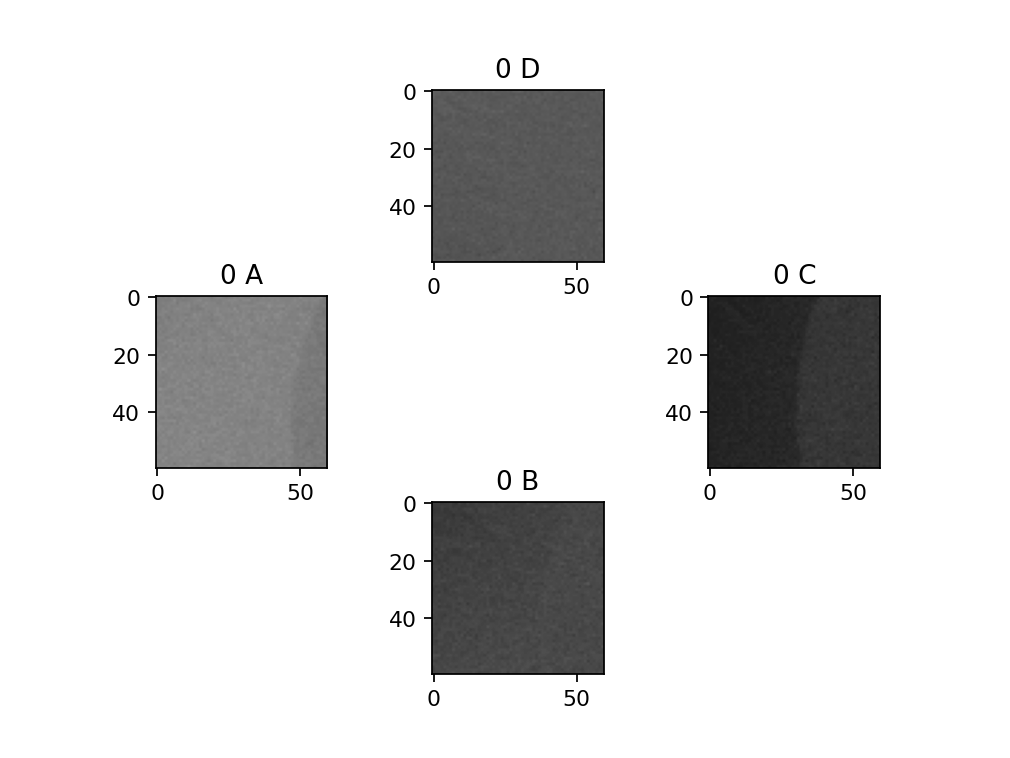

for segment  1
nx= 61
ny= 61
0 1 8.197438692725518
0 2 -37.20291624418952
0 3 -22.688250680131496
1 2 -4.040625177777596
1 3 -24.4823122314223
2 3 43.88819503255822
Correlation score = 67.14086404238235



<IPython.core.display.Javascript object>


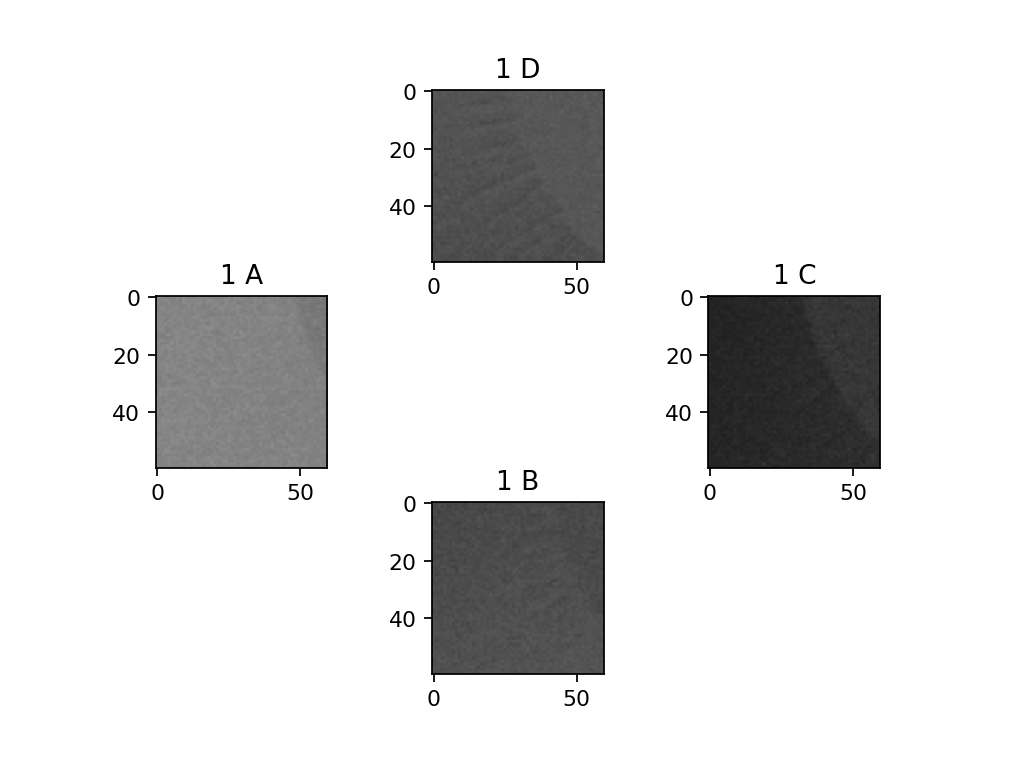

for segment  2
nx= 61
ny= 61
0 1 -9.629856771796995
0 2 -9.30580342729826
0 3 2.7038324192355847
1 2 10.75304011136585
1 3 -20.39986438249652
2 3 14.285615154107084
Correlation score = 30.372750409146303



<IPython.core.display.Javascript object>


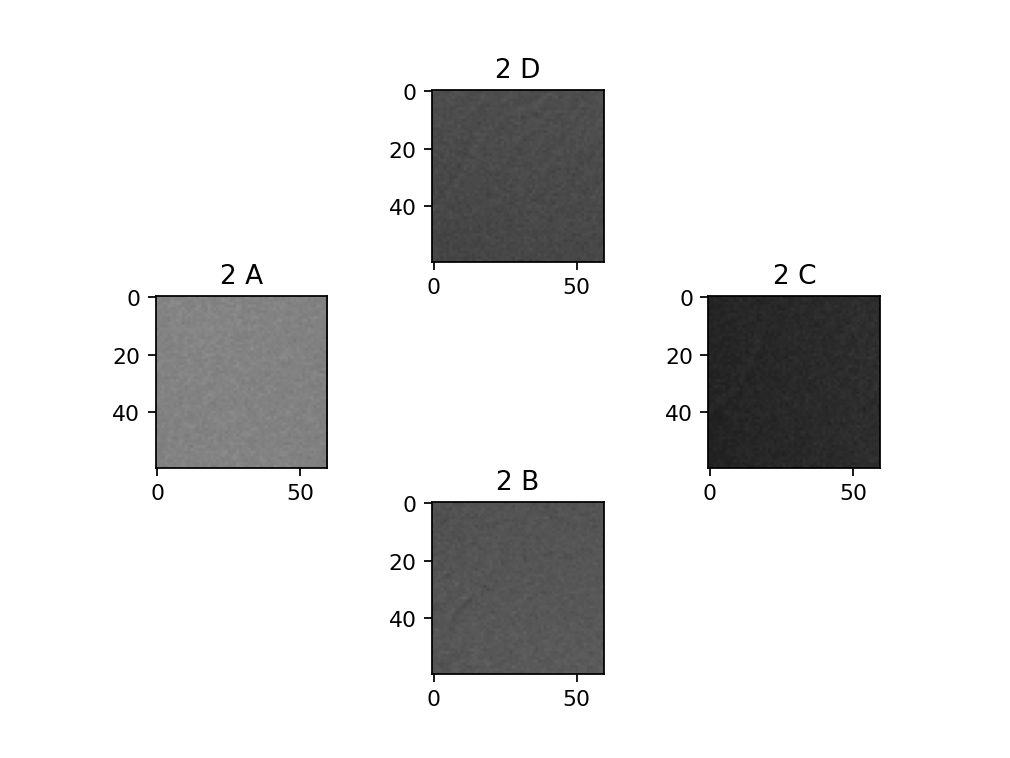

for segment  3
nx= 61
ny= 61
0 1 -2.7685297897140257
0 2 -1.9639405952247908
0 3 -0.2806423652416565
1 2 2.4441974037990106
1 3 2.077407997035052
2 3 1.3899483495259086
Correlation score = 4.880805399163864



<IPython.core.display.Javascript object>


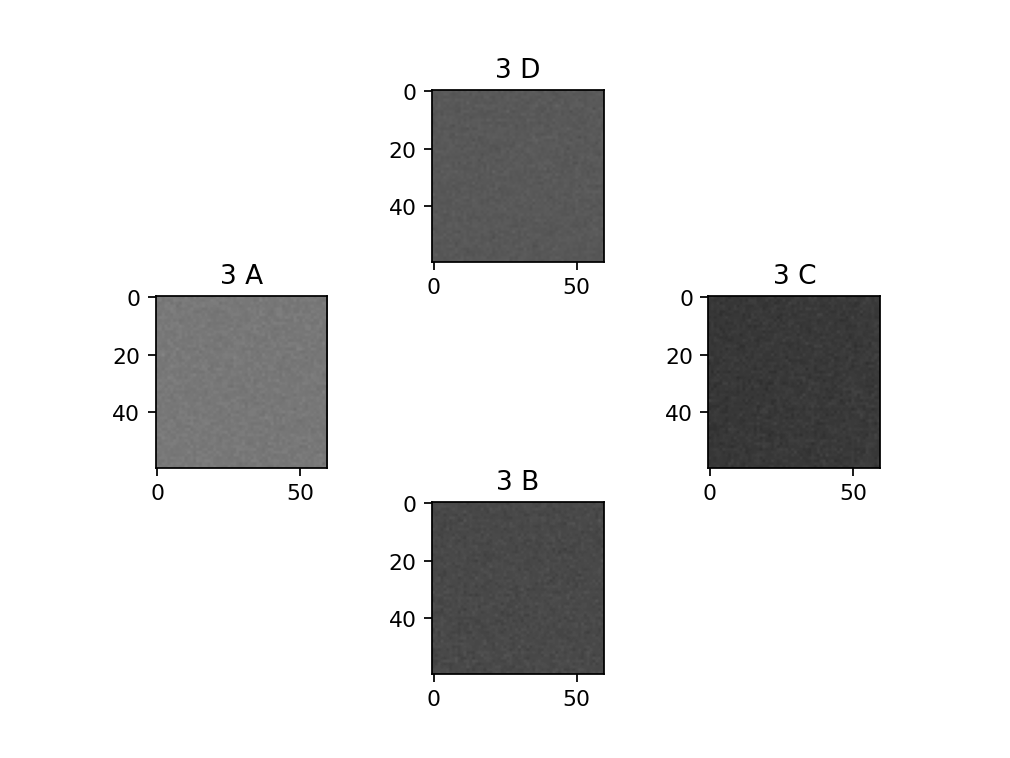

for segment  4
nx= 61
ny= 61
0 1 20.63427633848117
0 2 -9.980232999520089
0 3 -5.830145398788716
1 2 -6.681392994541616
1 3 -4.062629736040447
2 3 5.3850536953410915
Correlation score = 25.485560267137693



<IPython.core.display.Javascript object>


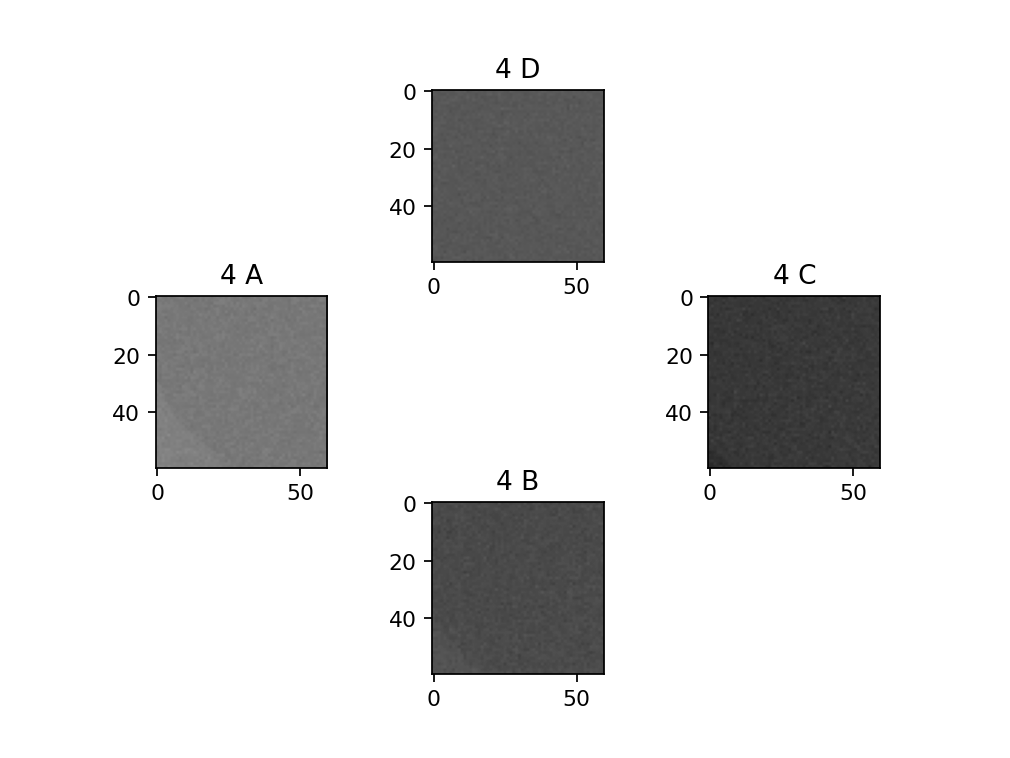

for segment  5
nx= 61
ny= 61
0 1 16.49312341593056
0 2 -36.99229757682625
0 3 -22.312087972120423
1 2 -28.104521984487874
1 3 -57.08012834648185
2 3 39.38894267303884
Correlation score = 87.96463199848316



<IPython.core.display.Javascript object>


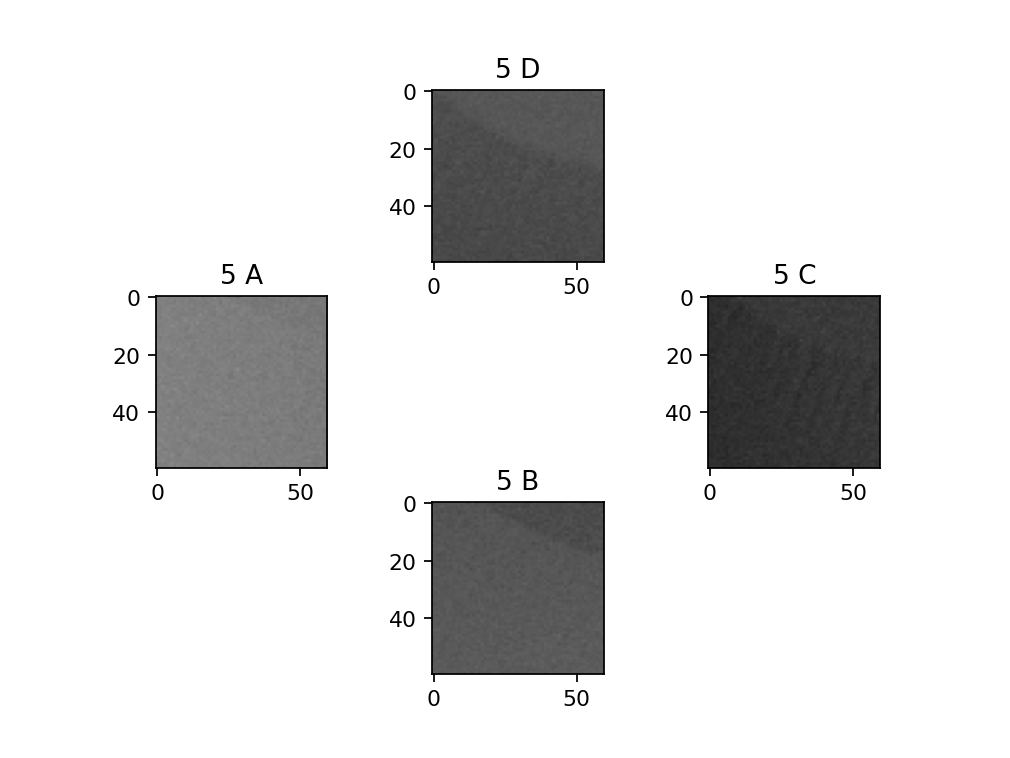

for segment  6
nx= 61
ny= 61
0 1 -2.443216208684058
0 2 -3.631186319862411
0 3 2.209486534863471
1 2 1.8295434765615453
1 3 -0.3377202703987688
2 3 0.23171591636302935
Correlation score = 5.248964360637105



<IPython.core.display.Javascript object>


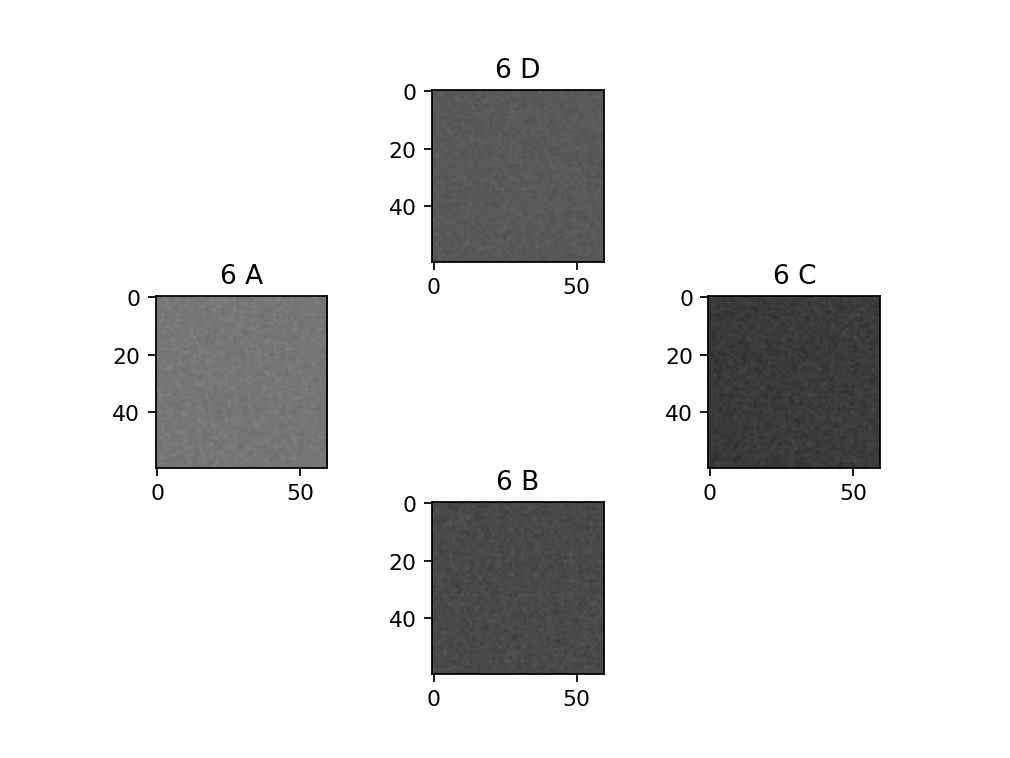

for segment  7
nx= 61
ny= 61
0 1 -1.9048416084734048
0 2 -1.8497255943661959
0 3 -0.09734578028909437
1 2 -0.2662199640778336
1 3 -2.3128363207199567
2 3 0.15056877884003128
Correlation score = 3.535836308660431



<IPython.core.display.Javascript object>


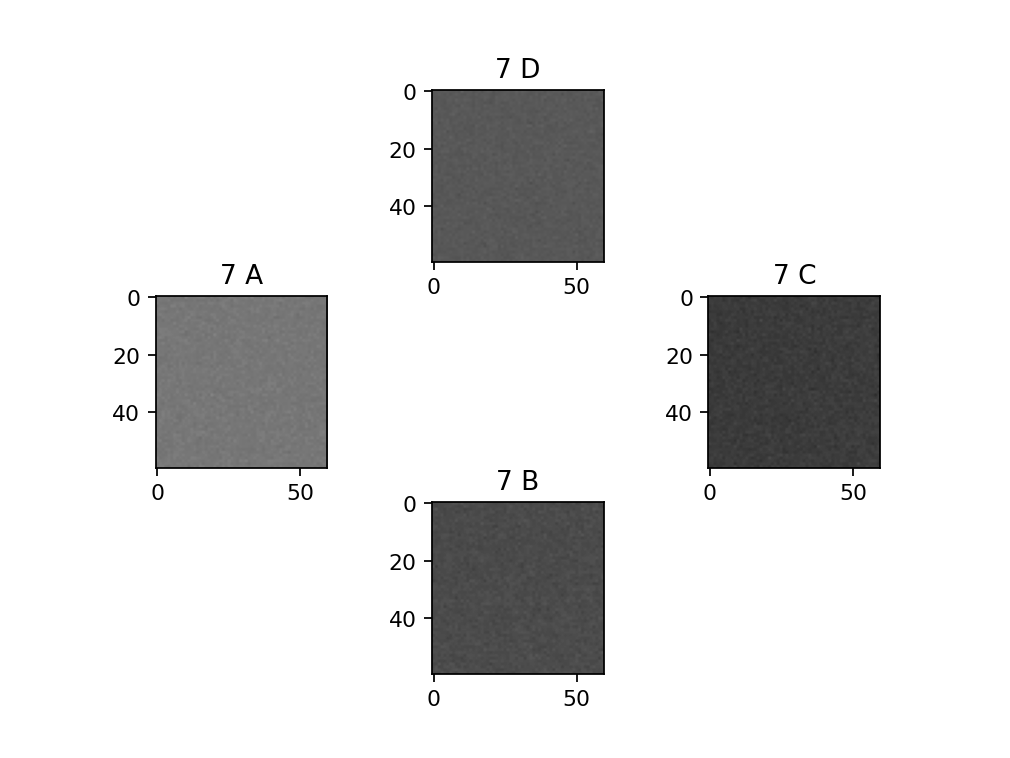

for segment  8
nx= 61
ny= 61
0 1 -9.88825636790726
0 2 -18.20443874000408
0 3 7.75295699111842
1 2 8.483823468897187
1 3 -68.10240331981599
2 3 -6.394023950780596
Correlation score = 72.38842232575318



<IPython.core.display.Javascript object>


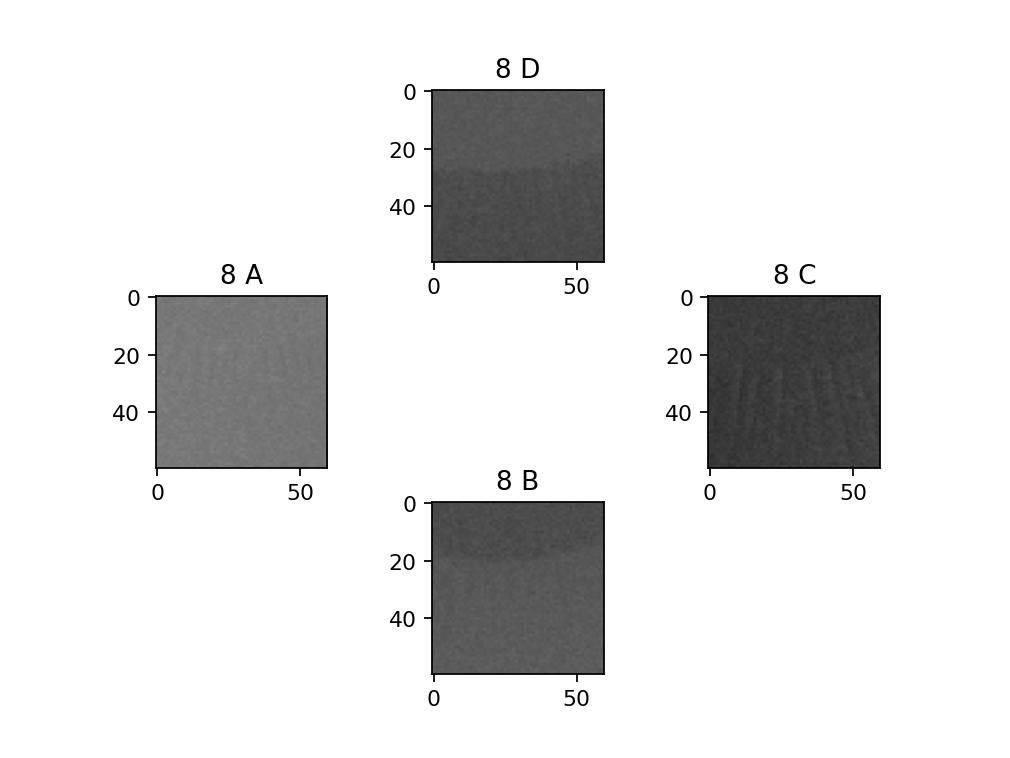

for segment  9
nx= 61
ny= 61
0 1 -0.42330137867274575
0 2 0.37317827260546915
0 3 0.9147331469281771
1 2 0.6966385538226955
1 3 -1.8000406595124845
2 3 -1.1684913547304057
Correlation score = 2.499201173789375



<IPython.core.display.Javascript object>


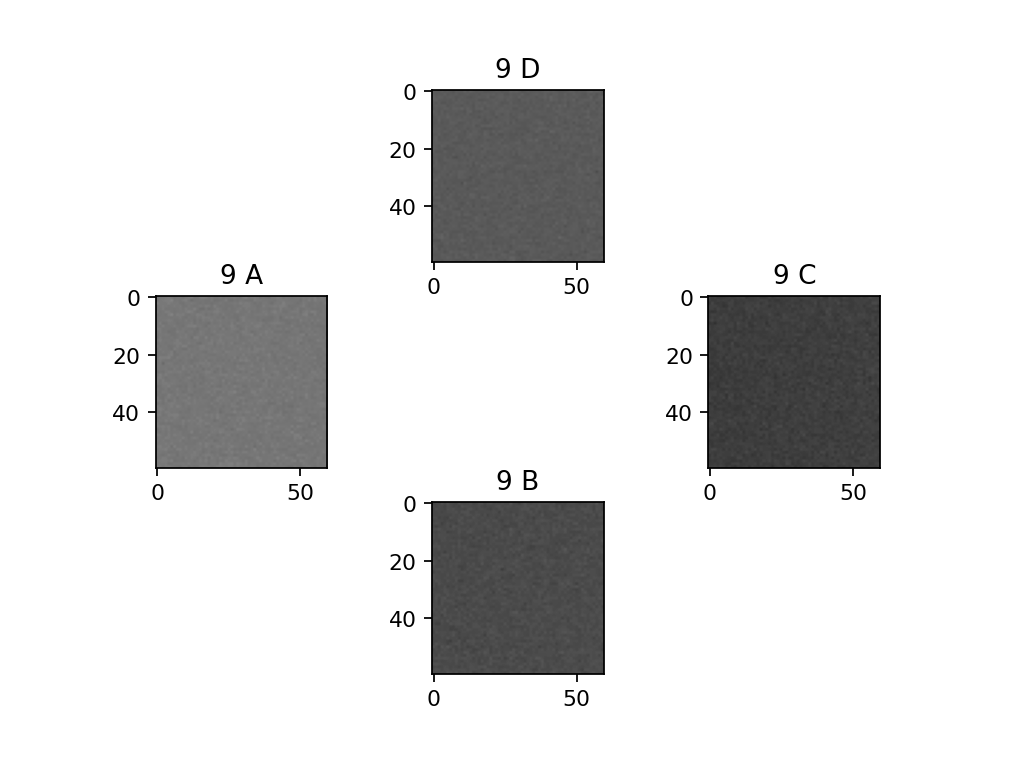

for segment  10
nx= 61
ny= 61
0 1 -34.93913272971535
0 2 -30.43219967571811
0 3 15.563588260875076
1 2 31.10890468101027
1 3 -15.407024876153796
2 3 -15.349147441394756
Correlation score = 61.88556976974334



<IPython.core.display.Javascript object>


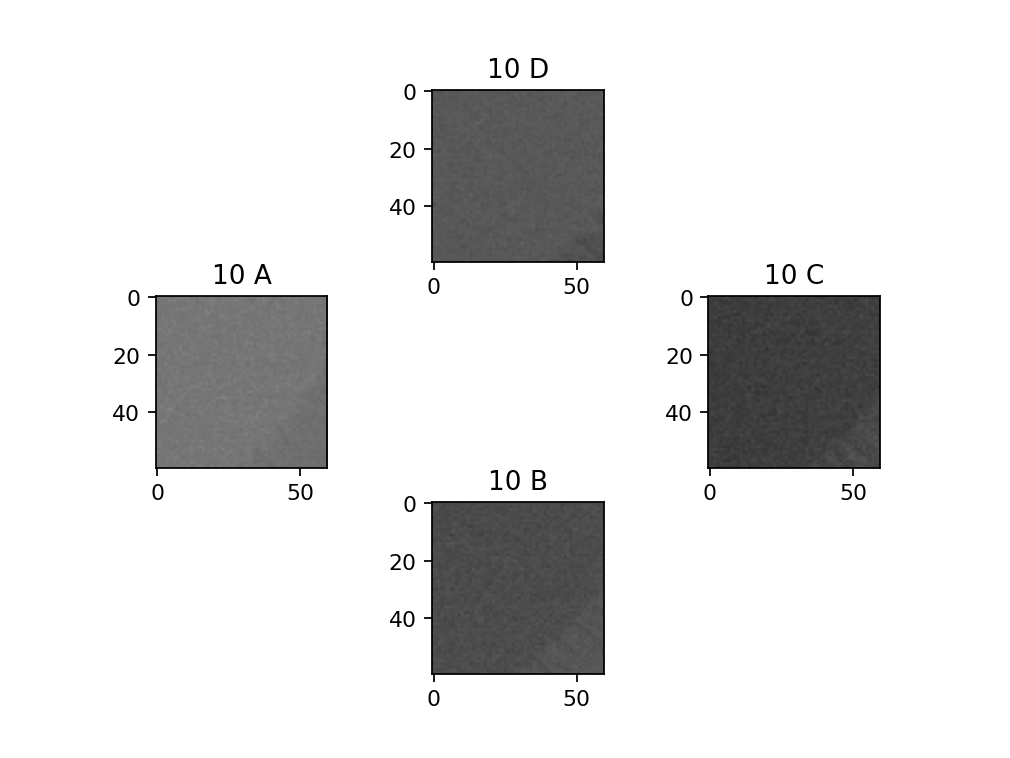

for segment  11
nx= 61
ny= 61
0 1 -26.137232767167323
0 2 -36.76618418621613
0 3 27.116965551748056
1 2 28.40977818424802
1 3 -53.058437100287826
2 3 -22.10506475430386
Correlation score = 82.95290343845649



<IPython.core.display.Javascript object>


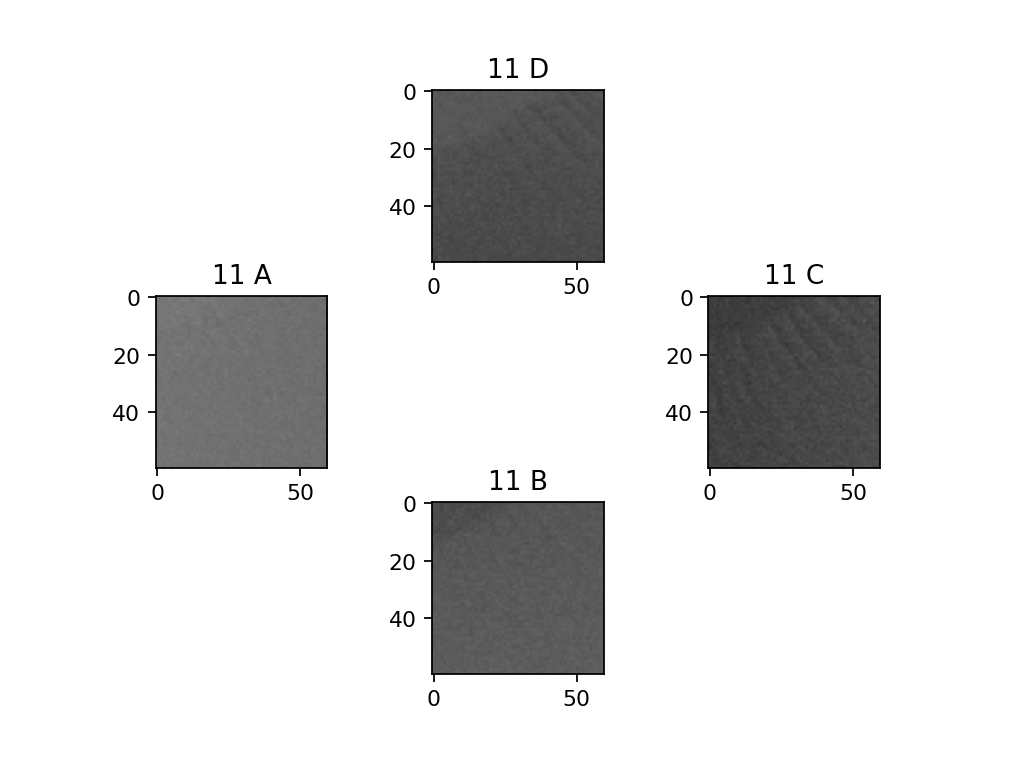

for segment  12
nx= 61
ny= 61
0 1 -10.596841026322304
0 2 -66.55534514139796
0 3 6.9935702195444485
1 2 10.900197008615862
1 3 -15.025863785362281
2 3 -7.528641760594009
Correlation score = 70.65471219335417



<IPython.core.display.Javascript object>


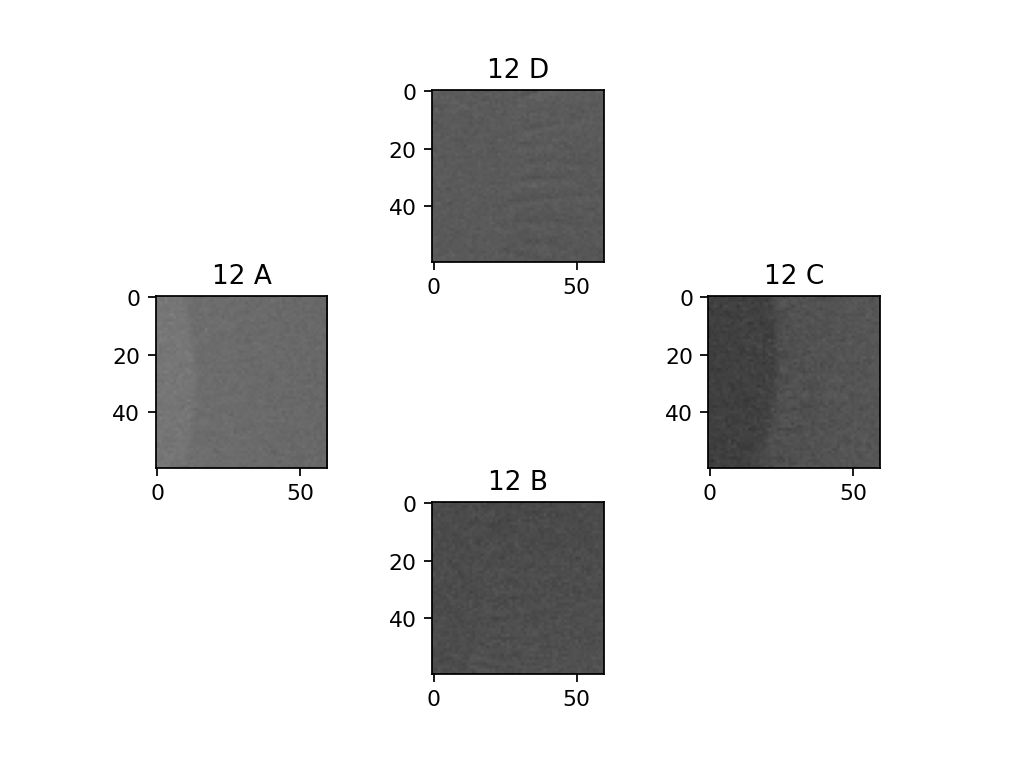

for segment  13
nx= 61
ny= 61
0 1 -20.654205572097013
0 2 -50.02489003375459
0 3 22.467688029807746
1 2 22.881932069618614
1 3 -34.306949998922164
2 3 -23.34868249792068
Correlation score = 75.36307745815813



<IPython.core.display.Javascript object>


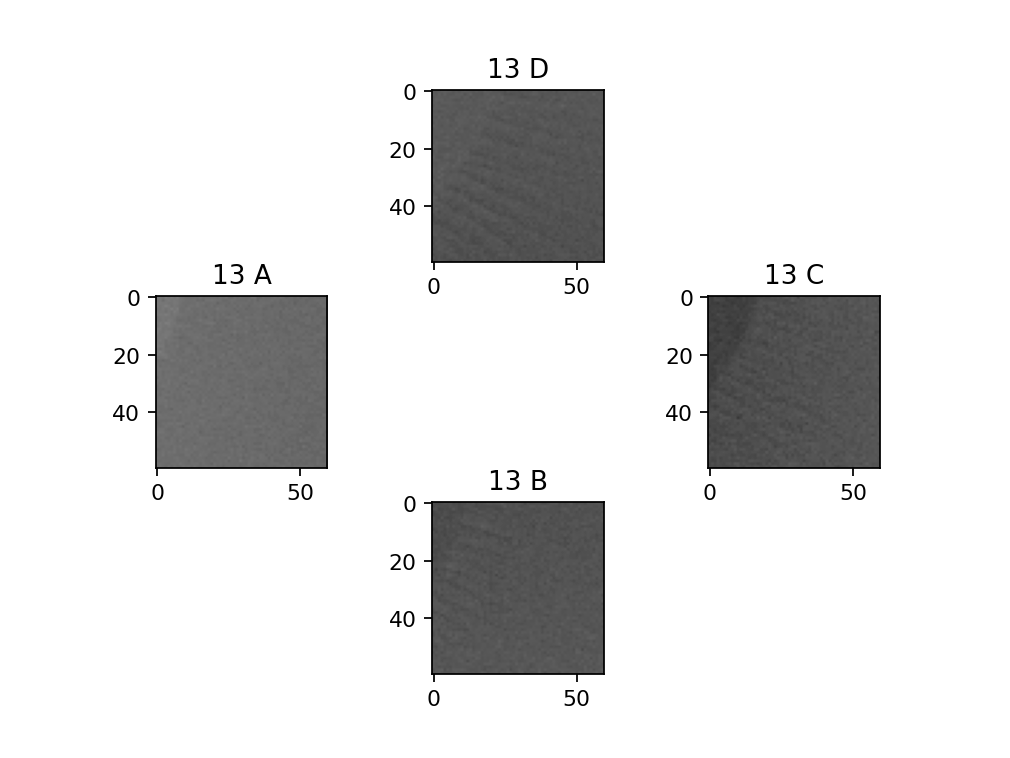

for segment  14
nx= 61
ny= 61
0 1 -28.583853384537356
0 2 -48.45146254599362
0 3 10.405808938758716
1 2 19.81510648620664
1 3 -26.264479876979557
2 3 -5.511833299575001
Correlation score = 66.22464353558107



<IPython.core.display.Javascript object>


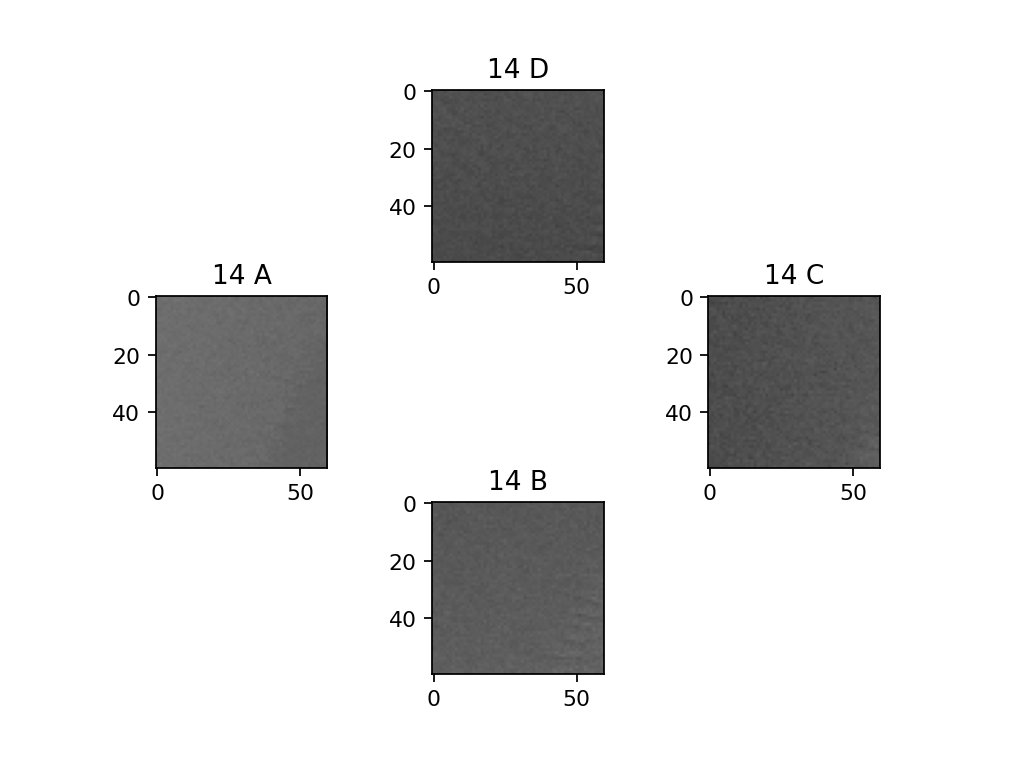

<IPython.core.display.Javascript object>


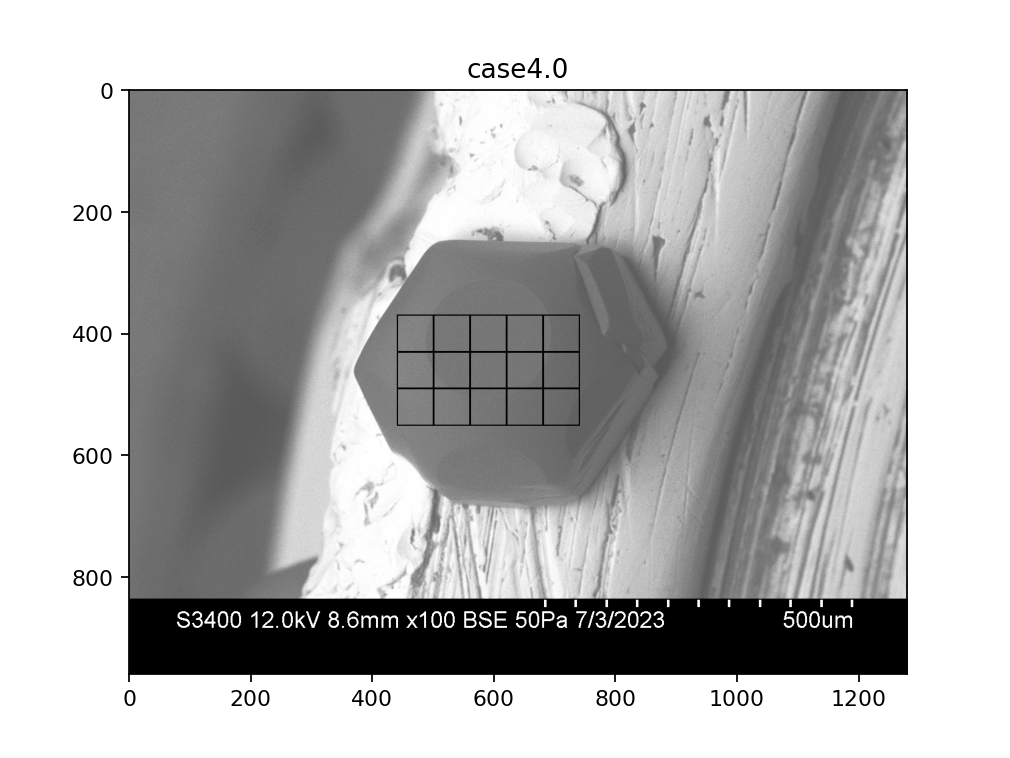

In [276]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [277]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

Calibration.nml


In [278]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [279]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [280]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [281]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [282]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [283]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [284]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 15 )
for 440 370
Observed intensities (detector B):
mean, max, min = 54.70944444444444 69.0 42.0
<diff>, std(diff), di2 = 0.7069780175628351 12.322665671920417 74990.99061267113
<diff>, std(diff), di2 = 1.5985943123891158 4.517076679782872 1995.1511172237351
<diff>, std(diff), di2 = 1.646170861256724 3.9370333329261338 16.74921052106996
<diff>, std(diff), di2 = 1.6458385323387867 3.920331342361618 0.2029311216923223

Segment: 1 ( 2 of 15 )
for 440 430
Observed intensities (detector B):
mean, max, min = 60.818333333333335 74.0 50.0
<diff>, std(diff), di2 = 1.2561446842295017 12.780794277869374 83513.4985386933
<diff>, std(diff), di2 = 1.6242608272574468 4.204402197886345 2084.171921738288
<diff>, std(diff), di2 = 1.6065959732353257 3.55662800555134 17.610145719750353
<diff>, std(diff), di2 = 1.6050927083129727 3.540547555347054 0.1425660692829785
Noverlap = 61

Segment: 2 ( 3 of 15 )
for 440 490
Observed intensities (detector B):
mean, max, min = 67.72277777777778 82.

300
180


<IPython.core.display.Javascript object>


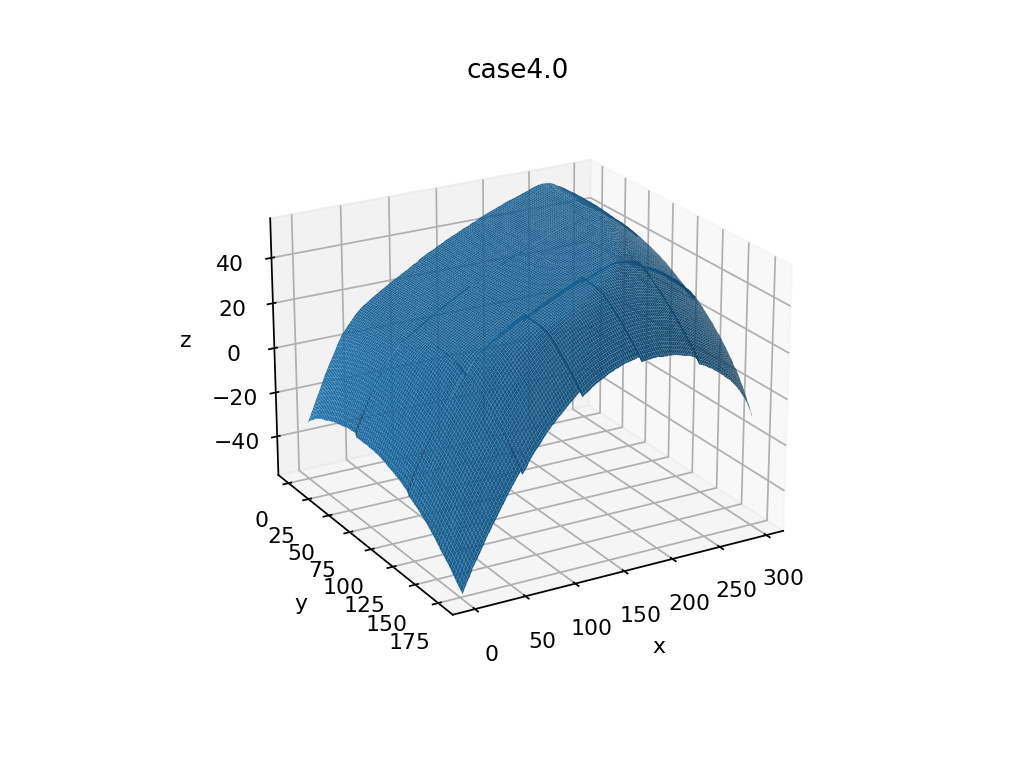

In [285]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [286]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments6_retrieved
